In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")

dataset = 'MNIST'
img_size = (32, 32, 3)  if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 512
inference_batch_size = 64
lr = 5e-5
epochs = 200

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# normalize = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
transform = transforms.Compose([
    # transforms.Resize(img_size[:2]),
    transforms.ToTensor(),
    # transforms.Normalize(*normalize)
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = CIFAR10(dataset_path, transform=transform, train=False, download=True)
else:
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:14<00:00, 678885.62it/s] 


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 110371.09it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:08<00:00, 192357.66it/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1412301.04it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [4]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [5]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        
        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y

class Denoiser(nn.Module):
    
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                
                               
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)
        
        
    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x
        
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))
        
        y = self.in_project(y)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)
            
        y = self.out_project(y)
            
        return y
    
model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims, 
                 diffusion_time_embedding_dim=timestep_embedding_dim, 
                 n_times=n_timesteps).to(DEVICE)

In [7]:
from paintmind.stage1.vqmodel import GaussianDiffusion

class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
    
        super(Diffusion, self).__init__()
    
        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model
        self.diffuser = GaussianDiffusion(num_timesteps=n_times, beta_start=beta_minmax[0], beta_end=beta_minmax[1])
        self.device = device
    
    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1
    
    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5
    
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        
        B, _, _, _ = x_zeros.shape
        
        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        
        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        noise = torch.randn_like(x_zeros).to(self.device)
        perturbed_images = self.diffuser.q_sample(x_zeros, t, noise)
        
        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_noise = self.model(perturbed_images, t)
        
        return perturbed_images, noise, pred_noise
                
    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        
        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.diffuser.p_sample(self.model, x_t, timestep)
        
        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        
        return x_0

In [9]:
diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps, 
                      beta_minmax=beta_minmax).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  4870913


In [11]:
model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_image(x, idx):
    # de_normalized = inverse_normalize(x[idx], normalize[0], normalize[1])
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

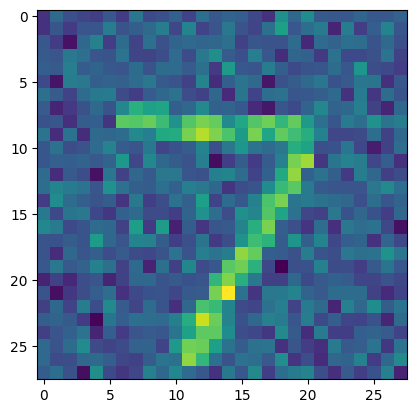

In [13]:
show_image(perturbed_images, idx=0)

In [14]:
print("Start training DDPMs...")
model.train()

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        x = x.to(DEVICE)
        
        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)
        
        noise_prediction_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)
    
print("Finish!!")

Start training DDPMs...


100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 1 complete! 	Denoising Loss:  0.18563750952991664



100%|██████████| 118/118 [00:34<00:00,  3.41it/s]

	Epoch 2 complete! 	Denoising Loss:  0.06568134693890555



100%|██████████| 118/118 [00:35<00:00,  3.30it/s]

	Epoch 3 complete! 	Denoising Loss:  0.04821503420288746



100%|██████████| 118/118 [00:34<00:00,  3.41it/s]

	Epoch 4 complete! 	Denoising Loss:  0.04235920112611901



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 5 complete! 	Denoising Loss:  0.03922423882744251



100%|██████████| 118/118 [00:34<00:00,  3.41it/s]

	Epoch 6 complete! 	Denoising Loss:  0.037261701563102566



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 7 complete! 	Denoising Loss:  0.03561018362768695



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 8 complete! 	Denoising Loss:  0.034478839041076154



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 9 complete! 	Denoising Loss:  0.033615897974779464



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 10 complete! 	Denoising Loss:  0.03319193617018879



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 11 complete! 	Denoising Loss:  0.03250871355143877



100%|██████████| 118/118 [00:34<00:00,  3.39it/s]

	Epoch 12 complete! 	Denoising Loss:  0.03181240696491849



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 13 complete! 	Denoising Loss:  0.031462975865245886



100%|██████████| 118/118 [00:34<00:00,  3.39it/s]

	Epoch 14 complete! 	Denoising Loss:  0.031085139745448388



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 15 complete! 	Denoising Loss:  0.031066093641595963



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 16 complete! 	Denoising Loss:  0.030504093163161196



100%|██████████| 118/118 [00:34<00:00,  3.39it/s]

	Epoch 17 complete! 	Denoising Loss:  0.030332900758864533



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 18 complete! 	Denoising Loss:  0.03002042207134585



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 19 complete! 	Denoising Loss:  0.029856123093865875



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 20 complete! 	Denoising Loss:  0.02960036537395074



100%|██████████| 118/118 [00:34<00:00,  3.39it/s]

	Epoch 21 complete! 	Denoising Loss:  0.02913150442843763



100%|██████████| 118/118 [00:35<00:00,  3.34it/s]

	Epoch 22 complete! 	Denoising Loss:  0.02958097503098667



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 23 complete! 	Denoising Loss:  0.029068578353040237



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 24 complete! 	Denoising Loss:  0.02880065854734335



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 25 complete! 	Denoising Loss:  0.0283924822942314



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 26 complete! 	Denoising Loss:  0.028593775521740954



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 27 complete! 	Denoising Loss:  0.028594983486920342



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 28 complete! 	Denoising Loss:  0.02803899432158368



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 29 complete! 	Denoising Loss:  0.02823859827322328



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 30 complete! 	Denoising Loss:  0.027995593431923125



100%|██████████| 118/118 [00:35<00:00,  3.35it/s]

	Epoch 31 complete! 	Denoising Loss:  0.028005031327533927



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 32 complete! 	Denoising Loss:  0.02760355332149909



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 33 complete! 	Denoising Loss:  0.027514925178809043



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 34 complete! 	Denoising Loss:  0.02767003671481059



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 35 complete! 	Denoising Loss:  0.02716387036200772



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 36 complete! 	Denoising Loss:  0.027035485555091474



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 37 complete! 	Denoising Loss:  0.0272787544144015



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 38 complete! 	Denoising Loss:  0.027234412268058866



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 39 complete! 	Denoising Loss:  0.02695653250074794



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 40 complete! 	Denoising Loss:  0.02701836585616454



100%|██████████| 118/118 [00:34<00:00,  3.39it/s]

	Epoch 41 complete! 	Denoising Loss:  0.02657870758866143



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 42 complete! 	Denoising Loss:  0.0269814932352712



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 43 complete! 	Denoising Loss:  0.02688861647859598



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 44 complete! 	Denoising Loss:  0.026338406719076328



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 45 complete! 	Denoising Loss:  0.02651945797678752



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 46 complete! 	Denoising Loss:  0.02646254872282346



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 47 complete! 	Denoising Loss:  0.027128519983882576



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 48 complete! 	Denoising Loss:  0.026321336802127015



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 49 complete! 	Denoising Loss:  0.0262943924142



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 50 complete! 	Denoising Loss:  0.026330600627976604



100%|██████████| 118/118 [00:34<00:00,  3.38it/s]

	Epoch 51 complete! 	Denoising Loss:  0.02638786781229015



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 52 complete! 	Denoising Loss:  0.026433956514821094



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 53 complete! 	Denoising Loss:  0.026199119850101635



100%|██████████| 118/118 [00:34<00:00,  3.40it/s]

	Epoch 54 complete! 	Denoising Loss:  0.026201781888420764



 52%|█████▏    | 61/118 [00:18<00:16,  3.37it/s]


KeyboardInterrupt: 

In [15]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

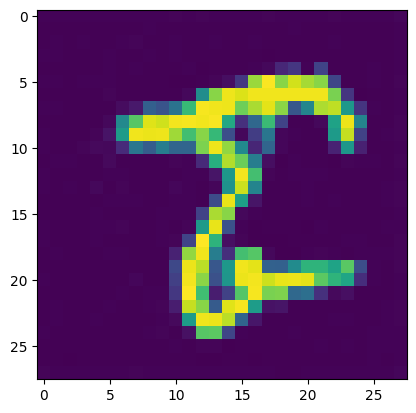

In [17]:
show_image(generated_images, idx=1)

In [18]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

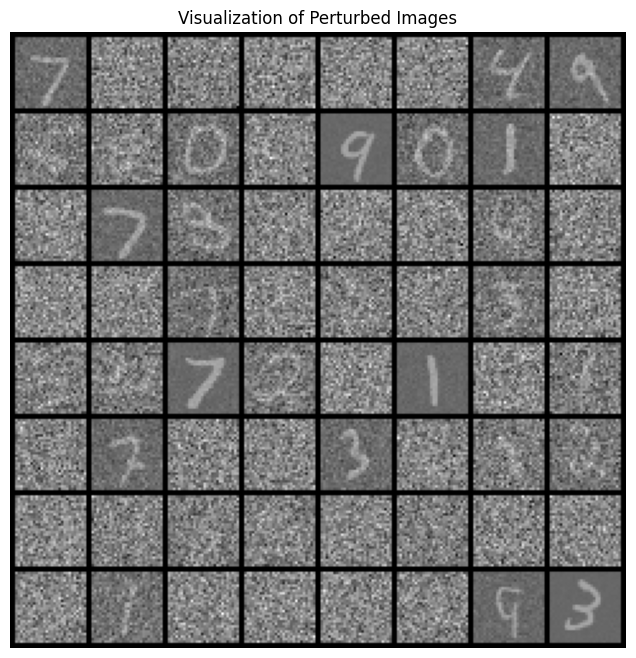

In [19]:
draw_sample_image(perturbed_images, "Perturbed Images")

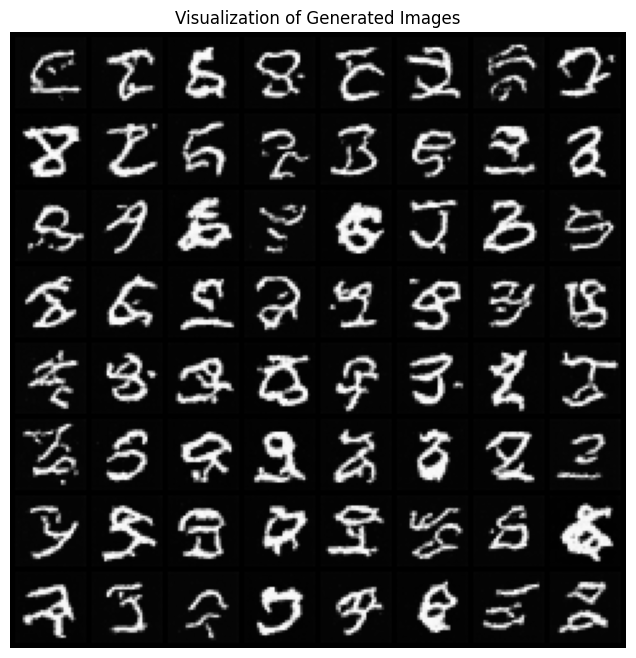

In [20]:
draw_sample_image(generated_images, "Generated Images")

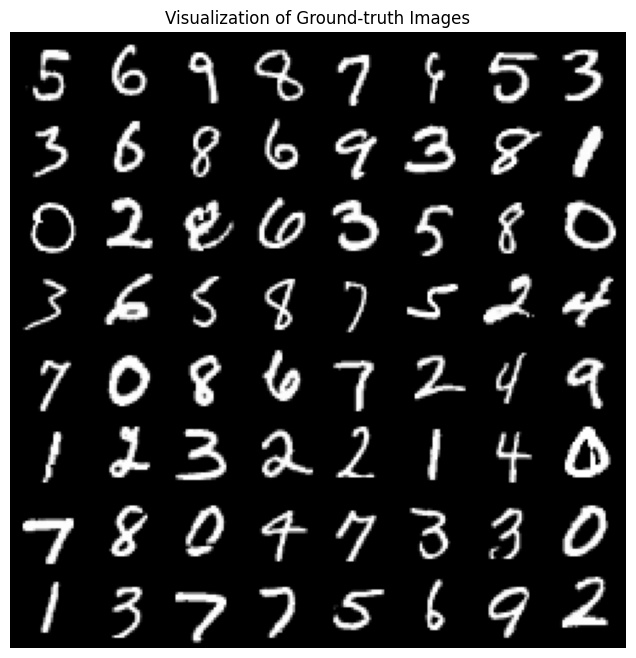

In [21]:
draw_sample_image(x[:inference_batch_size], "Ground-truth Images")